In [1]:
import os
import h5py
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def std_phi(phi):
    # return the phi in range [-pi, pi]
    while np.any(phi > np.pi):
        phi[phi > np.pi] -= 2 * np.pi
    while np.any(phi < -np.pi):
        phi[phi < -np.pi] += 2 * np.pi
    return phi

In [3]:
def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

# $\eta - \phi$ smearing

In [4]:
def eta_phi_smearing(origin_file, output_path, n=3):

    with h5py.File(origin_file, 'r') as f:
        nevent = f['EVENT/signal'].shape[0]
        print(nevent)
        pt1, pt2 = f['J1/pt'][:], f['J2/pt'][:]
        eta1, eta2 = f['J1/eta'][:], f['J2/eta'][:]
        phi1, phi2 = f['J1/phi'][:], f['J2/phi'][:]

    shutil.copyfile(origin_file, 'tmp.h5')
    shutil.copyfile(origin_file, output_path)

    with h5py.File(output_path, 'a') as f_out:
        keys = get_dataset_keys(f_out)

        std_scale = 0.1

        total_size = nevent
        for i in tqdm(range(n)):
            total_size += nevent
            with h5py.File('tmp.h5', 'a') as f_tmp:
                
                std_1 = np.divide(std_scale, pt1, out=np.zeros_like(pt1), where=(pt1!=0))
                std_2 = np.divide(std_scale, pt2, out=np.zeros_like(pt2), where=(pt2!=0))

                f_tmp['J1/eta'][:] = np.random.normal(loc=eta1, scale=std_1)
                f_tmp['J2/eta'][:] = np.random.normal(loc=eta2, scale=std_2)
                f_tmp['J1/phi'][:] = std_phi(np.random.normal(loc=phi1, scale=std_1))
                f_tmp['J2/phi'][:] = std_phi(np.random.normal(loc=phi2, scale=std_2))
            
                for key in keys:
                    f_out[key].resize(total_size, axis=0)
                    f_out[key][-nevent:] = f_tmp[key]

    os.remove('tmp.h5')

In [5]:
origin_file = './HVmodel/data/new/signal.h5'
output_path = './HVmodel/data/new/signal_aug_1.h5'

eta_phi_smearing(origin_file, output_path, n=1)

origin_file = './HVmodel/data/new/background_03.h5'
output_path = './HVmodel/data/new/background_aug_1.h5'

eta_phi_smearing(origin_file, output_path, n=1)

71923


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


49995


100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


In [6]:
for i in range(11):

    origin_file = f'./HVmodel/data/new/mix_sample_{i:.1f}.h5'
    output_path = f'./HVmodel/data/new/mix_sample_{i:.1f}_aug_1.h5'

    eta_phi_smearing(origin_file, output_path, n=1)

48289


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


48465


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


48643


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


48819


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


48997


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


49174


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


49351


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


49528


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


49705


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


49883


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


50060


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


# Plot

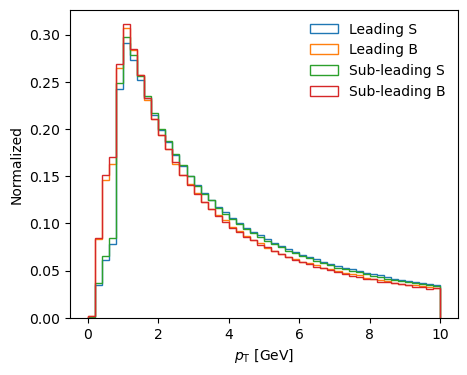

In [5]:
with h5py.File('./HVmodel/data/new/signal.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]

    pt1_s = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/pt'][:])])
    pt2_s = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/pt'][:])])

with h5py.File('./HVmodel/data/new/background_03.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]

    pt1_b = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/pt'][:])])
    pt2_b = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/pt'][:])])

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(pt1_s, bins=50, range=(0,10), histtype='step', label='Leading S', density=True)
ax.hist(pt1_b, bins=50, range=(0,10), histtype='step', label='Leading B', density=True)

ax.hist(pt2_s, bins=50, range=(0,10), histtype='step', label='Sub-leading S', density=True)
ax.hist(pt2_b, bins=50, range=(0,10), histtype='step', label='Sub-leading B', density=True)

ax.legend()
ax.set_xlabel('$p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

plt.savefig('../figures/hv_model_pt_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [6]:
with h5py.File('./HVmodel/data/new/signal.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1_ori_s = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
    eta2_ori_s = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/eta'][:])])

with h5py.File('./HVmodel/data/new/signal_aug_1.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1_aug_s = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
    eta2_aug_s = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/eta'][:])])

with h5py.File('./HVmodel/data/new/background_03.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1_ori_b = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
    eta2_ori_b = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/eta'][:])])

with h5py.File('./HVmodel/data/new/background_aug_1.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1_aug_b = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
    eta2_aug_b = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/eta'][:])])

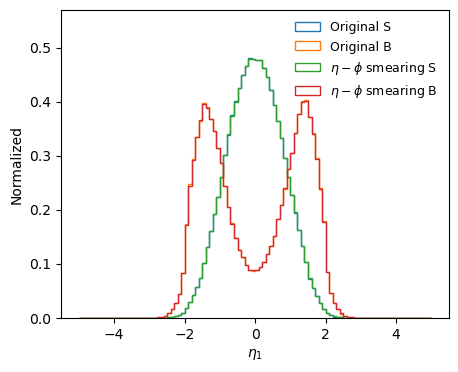

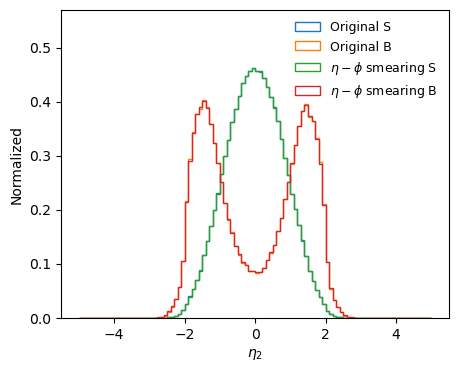

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(eta1_ori_s, bins=100, range=(-5, 5), histtype='step', label='Original S', density=True)
ax.hist(eta1_ori_b, bins=100, range=(-5, 5), histtype='step', label='Original B', density=True)
ax.hist(eta1_aug_s, bins=100, range=(-5, 5), histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(eta1_aug_b, bins=100, range=(-5, 5), histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('Normalized')
ax.set_ylim(0, 0.57)
ax.legend(frameon=False, fontsize=9, loc='upper right')

plt.savefig('../figures/hv_model_eta1_distribution_eta_phi_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(eta2_ori_s, bins=100, range=(-5, 5), histtype='step', label='Original S', density=True)
ax.hist(eta2_ori_b, bins=100, range=(-5, 5), histtype='step', label='Original B', density=True)
ax.hist(eta2_aug_s, bins=100, range=(-5, 5), histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(eta2_aug_b, bins=100, range=(-5, 5), histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$\eta_2$')
ax.set_ylabel('Normalized')
ax.set_ylim(0, 0.57)
ax.legend(frameon=False, fontsize=9, loc='upper right')

plt.savefig('../figures/hv_model_eta2_distribution_eta_phi_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

In [8]:
with h5py.File('./HVmodel/data/new/signal.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    phi1_ori_s = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/phi'][:])])
    phi2_ori_s = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/phi'][:])])

with h5py.File('./HVmodel/data/new/signal_aug_1.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    phi1_aug_s = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/phi'][:])])
    phi2_aug_s = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/phi'][:])])

with h5py.File('./HVmodel/data/new/background_03.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    phi1_ori_b = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/phi'][:])])
    phi2_ori_b = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/phi'][:])])

with h5py.File('./HVmodel/data/new/background_aug_1.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    phi1_aug_b = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/phi'][:])])
    phi2_aug_b = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/phi'][:])])

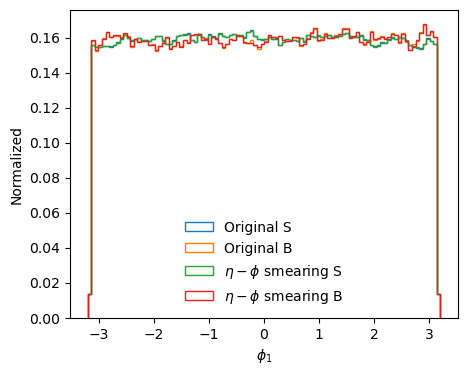

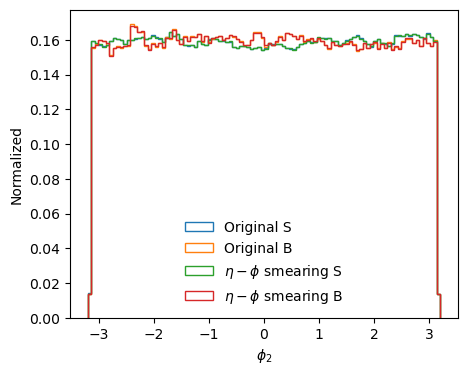

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(phi1_ori_s, bins=100, range=(-3.2, 3.2), histtype='step', label='Original S', density=True)
ax.hist(phi1_ori_b, bins=100, range=(-3.2, 3.2), histtype='step', label='Original B', density=True)
ax.hist(phi1_aug_s, bins=100, range=(-3.2, 3.2), histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(phi1_aug_b, bins=100, range=(-3.2, 3.2), histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='lower center')

plt.savefig('../figures/hv_model_phi1_distribution_eta_phi_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(phi2_ori_s, bins=100, range=(-3.2, 3.2), histtype='step', label='Original S', density=True)
ax.hist(phi2_ori_b, bins=100, range=(-3.2, 3.2), histtype='step', label='Original B', density=True)
ax.hist(phi2_aug_s, bins=100, range=(-3.2, 3.2), histtype='step', label='$\eta - \phi$ smearing S', density=True)
ax.hist(phi2_aug_b, bins=100, range=(-3.2, 3.2), histtype='step', label='$\eta - \phi$ smearing B', density=True)

ax.legend()
ax.set_xlabel('$\phi_2$')
ax.set_ylabel('Normalized')

ax.legend(frameon=False, loc='lower center')

plt.savefig('../figures/hv_model_phi2_distribution_eta_phi_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()